### Decide whether a sample is from a discrete or continuous distribution

The code below computes the Normalized Nearest Neighbor Distribution (NNN) and then uses the Wasserstein distance to quantify how far from uniform it lives. Discrete distributions have an NNN that is much farther from uniform than continuous distributions


In [1]:

import numpy as np
from scipy.stats import ks_2samp
from numpy.typing import NDArray
from scipy.stats import wasserstein_distance as emd

DISCRETE_MIN_EMD = 0.06 
CONTINUOUS_MIN_SAMPLE_SIZE = 20

def infer_discrete(X: NDArray, threshold: float = 0.05) -> NDArray:
    """Test for discreteness of a 1D sample.
    Imagine 1D data representing a sample of a continuous distribution, e.g. event times for emissions
    from a radioactive source. Think about the intervals between consecutive events; they have an exponential
    distribution. The most likely interval is zero, and longer intervals are exponentially less likely; 
    the average interval is the reciprocal of the decay rate. This stands in stark contrast with the tick
    times of a clock; the distribution of intervals between clock ticks is extremely sharply peaked; the 
    average and most likely intervals are in fact the same. Radioactive decay times and clock ticks 
    illustrate the fundamental distinction between continuous and discrete distributions.

    Of course, any 1D sample can be sorted in the way that times naturally are, and so we can think 
    about the intervals between adjacent points. For a continuous distribution, a point is equally likely 
    to lie anywhere in the interval bounded by its two neighbors. Furthermore, we can put all "between-
    neighbor" locations on the same scale of 0 to 1 by subtracting the smaller neighbor and dividing out
    the length of the interval. (Duplicates are either assigned to zero or ignored, depending on context). 
    These normalized locations will be much more uniformly distributed for continuous data than for discrete, 
    and this gives us a way to distinguish them. Call this the Normalized Near Neighbor distribution (NNN), 
    defined on the interval [0,1]. 

    The Wasserstein distance is available in scipy.stats.wasserstein_distance. We can use it to measure how close 
    the NNN is to a uniform distribution over [0,1]. We found that as long as a sample has at least 20 points, and
    furthermore at least half as many points as there are discrete values, we can reliably distinguish 
    discrete from continuous samples by testing that the Wasserstein distance is greater or less than 0.06, 
    respectively. 

    Example:

    >>> rng = np.random.default_rng(314159265)
    >>> Xnorm = rng.normal(100, scale=10, size=50)
    >>> print(f'Normal sample is discrete: {infer_discrete(Xnorm)[0]}')
    >>> Xfish = rng.poisson(100, size=50)
    >>> print(f'Poisson sample is discrete: {infer_discrete(Xfish)[0]}')
    >>> ks = ks_2samp(Xnorm, Xfish)
    >>> print(f'KS can distinguish Normal from Poisson: {ks.pvalue < 0.05}')
    Normal sample is discrete: False
    Poisson sample is discrete: True
    KS can distinguish Normal from Poisson: False
    """

    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    n_examples, n_features = X.shape

    if n_examples < CONTINUOUS_MIN_SAMPLE_SIZE:
        print(f'All samples look discrete with so few data points (< {CONTINUOUS_MIN_SAMPLE_SIZE})')
        return np.array([True]*n_features)

    shift = np.zeros(n_features)
    cvm = np.zeros(n_features)
    pval = np.zeros(n_features)
    dx = np.zeros(n_examples - 2)
    for i in range(n_features):
        Xs = np.sort(X[:, i])
        X0, X1 = Xs[0:-2], Xs[2:]

        gtz = (X1 - X0) > 0
        dx[gtz] = (Xs[1:-1] - X0)[gtz] / (X1 - X0)[gtz]
        dx[np.logical_not(gtz)] = 0.0

        shift[i] = emd(dx, np.linspace(0,1,len(dx)))

    return shift > DISCRETE_MIN_EMD

def _unicdf(x): # for x in range 0 to 1. 
    return x


In [2]:
rng = np.random.default_rng(314159265)
npts = 800
loc = 100
Xnorm = rng.normal(loc, scale=np.sqrt(loc), size=npts)
print(f'Normal sample is discrete: {infer_discrete(Xnorm)[0]}')
Xfish = rng.poisson(loc, size=npts)
print(f'Poisson sample is discrete: {infer_discrete(Xfish)[0]}')
ks = ks_2samp(Xnorm, Xfish)
print(f'KS can distinguish Normal from Poisson: {ks.pvalue < 0.05}') # type: ignore


Normal sample is discrete: False
Poisson sample is discrete: True
KS can distinguish Normal from Poisson: False


Text(0.5, 1.0, 'Similar distributions')

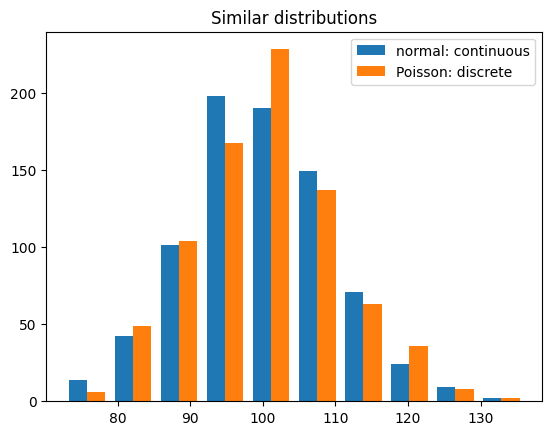

In [3]:
import matplotlib.pyplot as plt
plt.hist((Xnorm, Xfish));
plt.legend(['normal: continuous', 'Poisson: discrete'])
plt.title('Similar distributions')


Of course, the hist function bins both quantities and plots them as discrete. But the normal values are nevertheless from a continuous distribution.

The point is, the NNN and Wasserstein distance together provide a way to reasonably infer that a feature should be handled as discrete, for functions that want to know.
